<div style="text-align:center"><a href="https://en.wikipedia.org/wiki/London_Borough_of_Croydon"><img src = "https://upload.wikimedia.org/wikipedia/commons/7/7a/P1490912_The_Old_Town_Hall%2CKatherine_Street.._Croydon...jpg" width = 400> </a></div>

## Opening a Restaurant within Croydon

## A.1. Description and Discussion of Background

London is the capital of the United Kingdown. It is one of the largest financial hubs in the world. With a population of over 9 million people and being a very diverse city, large and small businesses thrive in different parts of the city. London is divided into 32 London boroughs and the City of London. 

In this study we would be exploring areas within one of the London Borough of Croydon, which is the largest London borough by population.

As the London Borough of Croydon has an extensive shopping district and night-time economy, restaurant owners and investors can benefit from this analysis to help determine what kind of restaurant to open to maximise profit.

It is important for restaurant owners to find a location that has a continuous stream of traffic, convenient parking, and is in proximity to other businesses.

A map will be created to show what kinds of restaurants are popular in the areas within Croydon. Based on our analysis we can determine the restaurant type and style of service that would be best suited for each area so that investors can make targeted decisions.  

In summary this analysis is targeted towards current and prospective restaurant owners within Croydon and is aimed at helping them determine what restaurant type would thrive in areas in Croydon.

## A.2. Data Description

The data below would be used for our analysis
- List of London Boroughs (Wikipedia) - This holds the coordinates of all the boroughs and local authorites within London
- List of areas of London (Wikipedia and Wikimedia) - This holds a list of areas in London with their coordinates; It would be cleaned and reduced to areas within the London Borough of Croydon and shown on a map
- Foursquare API will be used to get the most common venues within all the areas of interest.
- Each area will be analzed for unique venue categories
- Venues will be clustered and displayed on a map
- From our analysis we can determine what kinds of restaurants would thrive in different areas of Croydon


Download all the dependencies needed

In [24]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
import requests
import pandas as pd # library for data analsysis

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

### Download and Explore Dataset

List of London Boroughs (Wikipedia) - This holds the coordinates of all the boroughs and local authorites within London. 

Here we can find the centre of the borough. We would use this to centre the map later on.

In [25]:
croydon_latitude = 51.3714
croydon_longtitude = -0.0977

In [26]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text
soup = BeautifulSoup(source, 'lxml')
print(soup.title.text)

List of areas of London - Wikipedia


In [27]:
import re
tables = soup.find_all('table', class_="wikitable")
table = tables[0]

header = [];
rows = table.find_all('tr');
nonBreakSpace = u'\xa0'


for cell in rows[0].find_all('th'):
    header.append(cell.text.replace(nonBreakSpace, '_').replace(' ', '_'))

df = pd.DataFrame(columns=header)
  
for row in rows[1:]:
    row_data = [];
    for cell in row.find_all('td'):
        row_data.append(re.sub(r'\[[\d]\]', "", cell.text.rstrip()))
    df = df.append(pd.Series(row_data, index=df.columns), ignore_index=True)

df = df[df.London_borough == 'Croydon'].reset_index(drop=True)

df.head()


,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref
0,Addington,Croydon,CROYDON,CR0,020,TQ375645
1,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
2,Coombe,Croydon,CROYDON,CR0,020,TQ342647
3,Coulsdon,Croydon,COULSDON,CR5,"020, 01737",TQ298596
4,Croydon,Croydon,CROYDON,CR0,020,TQ335655


### Get Location Data

Location Data was sourced from GPS coordinates available on Wikimedia. 
Data was cleaned and transformed

In [28]:
source2 = requests.get('https://raw.githubusercontent.com/aniebiet/Coursera_Capstone/master/Capstone_Project/areas.gpx').text
soup2 = BeautifulSoup(source2, 'lxml')

In [29]:
wpts = soup2.find_all('wpt')

locs = pd.DataFrame(columns=['Location', 'Latitude', 'Longtitude'])
  
for row in wpts:
    row_data = [row.find('name').get_text().replace(', London', ''), row['lat'].rstrip(), row['lon'].rstrip()];    
    locs = locs.append(pd.Series(row_data, index=locs.columns), ignore_index=True)


locs.head()

,Location,Latitude,Longtitude
0,Abbey Wood,51.4864,0.1109
1,Acton,51.513519,-0.270661
2,Acton Green,51.510515,-0.262668
3,Acton Vale,51.511,-0.258
4,Addington,51.3583,-0.0305


### Merge Location Data and Area Data

In [30]:
df_outer = pd.merge(df, locs, on='Location', how='left')
df_outer.head()

,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref,Latitude,Longtitude
0,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.3583,-0.0305
1,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381,-0.0663
2,Coombe,Croydon,CROYDON,CR0,020,TQ342647,NaN,NaN
3,Coulsdon,Croydon,COULSDON,CR5,"020, 01737",TQ298596,51.3211,-0.1386
4,Croydon,Croydon,CROYDON,CR0,020,TQ335655,51.3727,-0.1099


### Replace NaN values by manually sourcing data

In [31]:
df_outer.loc[df_outer['Location'] == 'Coombe', 'Latitude'] = 51.3633
df_outer.loc[df_outer['Location'] == 'Coombe', 'Longtitude'] = -0.0696
df_outer.loc[df_outer['Location'] == 'South Norwood', 'Latitude'] = 51.3995
df_outer.loc[df_outer['Location'] == 'South Norwood', 'Longtitude'] = -0.0747
df_outer.loc[df_outer['Location'] == 'Woodside', 'Latitude'] = 51.387849
df_outer.loc[df_outer['Location'] == 'Woodside', 'Longtitude'] = -0.067509

croydon_data = df_outer
croydon_data['Latitude'] = croydon_data['Latitude'].astype(float)
croydon_data['Longtitude'] = croydon_data['Longtitude'].astype(float)
croydon_data.head()

,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref,Latitude,Longtitude
0,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.3583,-0.0305
1,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.3810,-0.0663
2,Coombe,Croydon,CROYDON,CR0,020,TQ342647,51.3633,-0.0696
3,Coulsdon,Croydon,COULSDON,CR5,"020, 01737",TQ298596,51.3211,-0.1386
4,Croydon,Croydon,CROYDON,CR0,020,TQ335655,51.3727,-0.1099


In [32]:

croydon_data

,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref,Latitude,Longtitude
0,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.358300,-0.030500
1,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381000,-0.066300
2,Coombe,Croydon,CROYDON,CR0,020,TQ342647,51.363300,-0.069600
3,Coulsdon,Croydon,COULSDON,CR5,"020, 01737",TQ298596,51.321100,-0.138600
4,Croydon,Croydon,CROYDON,CR0,020,TQ335655,51.372700,-0.109900
5,Forestdale,Croydon,CROYDON,CR0,020,TQ366625,51.345000,-0.038000
6,Kenley,Croydon,KENLEY,CR8,020,TQ327600,51.324200,-0.096900
7,New Addington,Croydon,CROYDON,CR0,020,TQ382622,51.342700,-0.016700
8,Norbury,Croydon,LONDON,SW16,020,TQ315695,51.409200,-0.108300
9,Old Coulsdon,Croydon,COULSDON,CR5,01737,TQ315575,51.301800,-0.114300


## Create a map of Croydon with areas superimposed on top.

We create a map of Croydon with areas superimposed using Folium

In [33]:
# Map of Croydon 
map_croydon = folium.Map(location=[croydon_latitude, croydon_longtitude], zoom_start=12)

# Markers
for lat, lng, location, town, postcode in zip(croydon_data['Latitude'], croydon_data['Longtitude'], croydon_data['Location'], croydon_data['Post_town'], croydon_data['Postcode_district']):
    label = '{}, {}, {}'.format(location, town, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_croydon)  
    
map_croydon

#### Define Foursquare Credentials 

In [34]:
CLIENT_ID = 'XFVZTA3J1TNYQQ4SEXMXH5R0UUHVTKYSG23YEUE2JEKPCLCW' # your Foursquare ID
CLIENT_SECRET = 'EQO0APF0IAOMC0Z42DO0SNOPBE0Z3T5H0DWRKYWZCPZUY3EN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# Define Limits and radius
LIMIT = 200
radius = 500

#### Get Nearby Venues

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Latitude', 
                  'Longtitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longtitude', 
                  'Venue Category']
    
    return(nearby_venues)


croydon_venues = getNearbyVenues(names=croydon_data['Location'],
                                   latitudes=croydon_data['Latitude'],
                                   longitudes=croydon_data['Longtitude']
                                  )


Addington
Addiscombe
Coombe
Coulsdon
Croydon
Forestdale
Kenley
New Addington
Norbury
Old Coulsdon
Purley
Riddlesdown
Sanderstead
Selhurst
Selsdon
Shirley
South Croydon
South Norwood
Thornton Heath
Upper Norwood
Waddon
Woodside


Take a look at the empty dataframe to confirm that the columns are as intended.

In [36]:
print(croydon_venues.shape)
croydon_venues.head()

(172, 7)


,Location,Latitude,Longtitude,Venue,Venue Latitude,Venue Longtitude,Venue Category
0,Addington,51.3583,-0.0305,Shell,51.357047,-0.033468,Gas Station
1,Addington,51.3583,-0.0305,The Cricketers (Harvester),51.357833,-0.032844,English Restaurant
2,Addington,51.3583,-0.0305,Addington Village Interchange,51.356374,-0.032680,Bus Station
3,Addington,51.3583,-0.0305,Addington Village London Tramlink Stop,51.356276,-0.032923,Tram Station
4,Addiscombe,51.3810,-0.0663,The Tram Stop,51.380188,-0.073378,Café


Then let's loop through the data and fill the dataframe one row at a time.

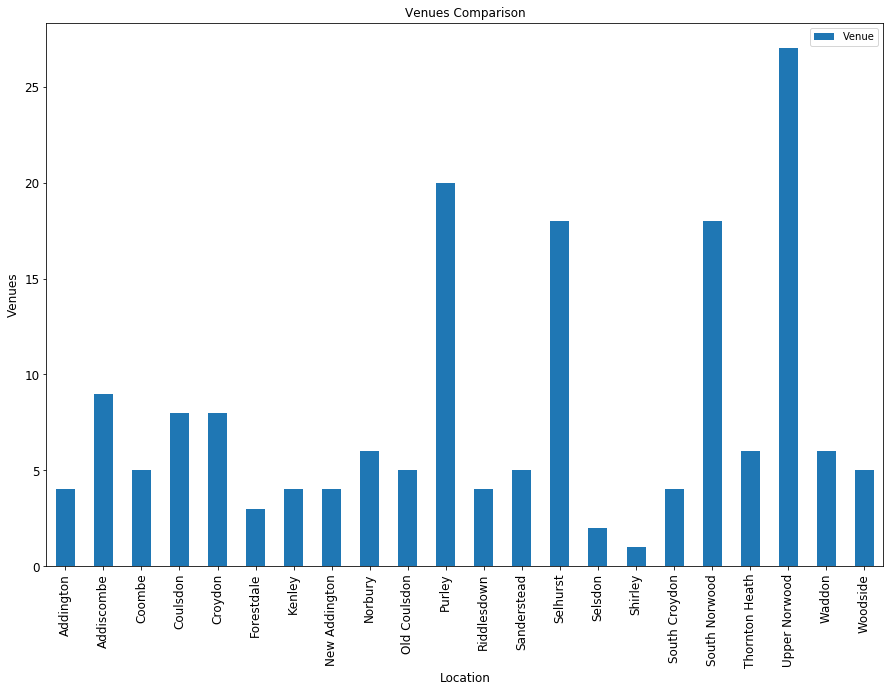

In [37]:
croydon_venue_list = croydon_venues.groupby('Location').count()[['Venue']]
croydon_venue_list
ax = croydon_venue_list.plot(kind='bar', title ="Venues Comparison", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Location", fontsize=12)
ax.set_ylabel("Venues", fontsize=12)
ax

Quickly examine the resulting dataframe.

In [38]:
print('There are {} uniques categories.'.format(len(croydon_venues['Venue Category'].unique())))

There are 61 uniques categories.


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [39]:
# one hot encoding
croydon_onehot = pd.get_dummies(croydon_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
croydon_onehot['Location'] = croydon_venues['Location'] 

# move neighborhood column to the first column
fixed_columns = [croydon_onehot.columns[-1]] + list(croydon_onehot.columns[:-1])
croydon_onehot = croydon_onehot[fixed_columns]

croydon_onehot.head()

,Location,African Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Betting Shop,Bookstore,Bus Station,Bus Stop,Café,Campground,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Diner,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Truck,French Restaurant,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hotel,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Newsstand,Park,Pharmacy,Pizza Place,Platform,Pool,Portuguese Restaurant,Pub,Recreation Center,Restaurant,Sandwich Place,Sports Bar,Supermarket,Tapas Restaurant,Thai Restaurant,Train Station,Tram Station,Turkish Restaurant,Warehouse Store,Waste Facility
0,Addington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Addington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Addington,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Addington,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Addiscombe,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
croydon_onehot.shape

(172, 62)

#### Group rows by neighborhood and take the mean of the frequency of occurrence of each category

In [76]:
croydon_grouped = croydon_onehot.groupby('Location').mean().reset_index()
croydon_grouped.head()

,Location,African Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Betting Shop,Bookstore,Bus Station,Bus Stop,Café,Campground,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Diner,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Truck,French Restaurant,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hotel,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Newsstand,Park,Pharmacy,Pizza Place,Platform,Pool,Portuguese Restaurant,Pub,Recreation Center,Restaurant,Sandwich Place,Sports Bar,Supermarket,Tapas Restaurant,Thai Restaurant,Train Station,Tram Station,Turkish Restaurant,Warehouse Store,Waste Facility
0,Addington,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.000,0.000,0.0,0.000,0.0,0.25,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.25,0.0,0.000,0.0
1,Addiscombe,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.00,0.0,0.222222,0.0,0.000,0.000,0.0,0.000,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.333333,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.000,0.0
2,Coombe,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.200000,0.0,0.000,0.000,0.0,0.000,0.0,0.00,0.000,0.0,0.0,0.0,0.2,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.200000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.2,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.000,0.0
3,Coulsdon,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000,0.125,0.0,0.125,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.000000,0.125,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.00,0.0,0.000,0.0
4,Croydon,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.125,0.000,0.0,0.000,0.0,0.00,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.125000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.25,0.0,0.125,0.0


In [77]:
croydon_grouped.shape

(22, 62)

#### Top 5 venues for each Area in Croydon

In [20]:
num_top_venues = 5

for hood in croydon_grouped['Location']:
    print("----"+hood+"----")
    temp = croydon_grouped[croydon_grouped['Location'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Addington----
                      venue  freq
0               Bus Station  0.25
1              Tram Station  0.25
2        English Restaurant  0.25
3               Gas Station  0.25
4  Mediterranean Restaurant  0.00


----Addiscombe----
                venue  freq
0       Grocery Store  0.33
1                Park  0.33
2                Café  0.22
3              Bakery  0.11
4  African Restaurant  0.00


----Coombe----
               venue  freq
0              Hotel   0.2
1  French Restaurant   0.2
2               Café   0.2
3         Restaurant   0.2
4               Park   0.2


----Coulsdon----
               venue  freq
0        Supermarket  0.25
1           Pharmacy  0.12
2      Grocery Store  0.12
3  Convenience Store  0.12
4                Pub  0.12


----Croydon----
                venue  freq
0        Tram Station  0.25
1  Chinese Restaurant  0.12
2     Warehouse Store  0.12
3       Grocery Store  0.12
4                Park  0.12


----Forestdale----
                venue 

Let's get the geographical coordinates of Manhattan.

In [148]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# sorted location venues sorted
location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Location'] = croydon_grouped['Location']

for ind in np.arange(croydon_grouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(croydon_grouped.iloc[ind, :], num_top_venues)

location_venues_sorted.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addington,Tram Station,Gas Station,Bus Station,English Restaurant,Waste Facility,Convenience Store,Golf Course,Gastropub,Garden Center,Furniture / Home Store
1,Addiscombe,Park,Grocery Store,Café,Bakery,Food Truck,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Waste Facility
2,Coombe,Park,Restaurant,Hotel,Café,French Restaurant,Diner,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Waste Facility
3,Coulsdon,Supermarket,Coffee Shop,Convenience Store,Pub,Martial Arts Dojo,Pharmacy,Grocery Store,French Restaurant,Furniture / Home Store,Food Truck
4,Croydon,Tram Station,Grocery Store,Warehouse Store,Chinese Restaurant,Supermarket,Park,Fast Food Restaurant,Waste Facility,Fish & Chips Shop,Diner


## Cluster Neighborhoods

In [136]:
test_data = croydon_onehot
test_data= croydon_grouped.drop(croydon_grouped.columns[0], axis='columns')
test_data.head()

,African Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Betting Shop,Bookstore,Bus Station,Bus Stop,Café,Campground,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Diner,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food Truck,French Restaurant,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Home Service,Hotel,Indian Restaurant,Italian Restaurant,Latin American Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Newsstand,Park,Pharmacy,Pizza Place,Platform,Pool,Portuguese Restaurant,Pub,Recreation Center,Restaurant,Sandwich Place,Sports Bar,Supermarket,Tapas Restaurant,Thai Restaurant,Train Station,Tram Station,Turkish Restaurant,Warehouse Store,Waste Facility
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.000,0.000,0.0,0.000,0.0,0.25,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.25,0.0,0.000,0.0
1,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.00,0.0,0.222222,0.0,0.000,0.000,0.0,0.000,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.333333,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.000,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.200000,0.0,0.000,0.000,0.0,0.000,0.0,0.00,0.000,0.0,0.0,0.0,0.2,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.200000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.2,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.000,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000,0.125,0.0,0.125,0.0,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.000000,0.125,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.250,0.0,0.0,0.0,0.00,0.0,0.000,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.125,0.000,0.0,0.000,0.0,0.00,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.125000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.25,0.0,0.125,0.0


In [137]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(test_data)
data_transformed = mms.transform(test_data)

In [138]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

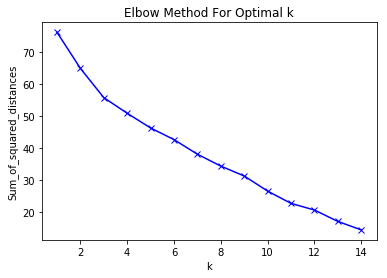

In [139]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [149]:
# set number of clusters
kclusters = 3

croydon_grouped_clustering = croydon_grouped.drop('Location', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(croydon_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 2, 0, 0, 2, 0, 0], dtype=int32)

In [150]:
# add clustering labels
location_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

croydon_merged = croydon_data

# merge croydon_merged with croydon_data to add latitude/longitude for each neighborhood
croydon_merged = croydon_merged.join(location_venues_sorted.set_index('Location'), on='Location')

croydon_merged.head()

,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref,Latitude,Longtitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.3583,-0.0305,2,Tram Station,Gas Station,Bus Station,English Restaurant,Waste Facility,Convenience Store,Golf Course,Gastropub,Garden Center,Furniture / Home Store
1,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.3810,-0.0663,0,Park,Grocery Store,Café,Bakery,Food Truck,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Waste Facility
2,Coombe,Croydon,CROYDON,CR0,020,TQ342647,51.3633,-0.0696,0,Park,Restaurant,Hotel,Café,French Restaurant,Diner,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Waste Facility
3,Coulsdon,Croydon,COULSDON,CR5,"020, 01737",TQ298596,51.3211,-0.1386,0,Supermarket,Coffee Shop,Convenience Store,Pub,Martial Arts Dojo,Pharmacy,Grocery Store,French Restaurant,Furniture / Home Store,Food Truck
4,Croydon,Croydon,CROYDON,CR0,020,TQ335655,51.3727,-0.1099,2,Tram Station,Grocery Store,Warehouse Store,Chinese Restaurant,Supermarket,Park,Fast Food Restaurant,Waste Facility,Fish & Chips Shop,Diner


In [157]:
# create map
map_clusters = folium.Map(location=[croydon_latitude, croydon_longtitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(croydon_merged['Latitude'], croydon_merged['Longtitude'], croydon_merged['Location'], croydon_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### Cluster 1

In [158]:
croydon_merged.loc[croydon_merged['Cluster Labels'] == 0, croydon_merged.columns[[0] + list(range(5, croydon_merged.shape[1]))]]

,Location,OS_grid_ref,Latitude,Longtitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Addiscombe,TQ345665,51.3810,-0.0663,0,Park,Grocery Store,Café,Bakery,Food Truck,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Waste Facility
2,Coombe,TQ342647,51.3633,-0.0696,0,Park,Restaurant,Hotel,Café,French Restaurant,Diner,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Waste Facility
3,Coulsdon,TQ298596,51.3211,-0.1386,0,Supermarket,Coffee Shop,Convenience Store,Pub,Martial Arts Dojo,Pharmacy,Grocery Store,French Restaurant,Furniture / Home Store,Food Truck
5,Forestdale,TQ366625,51.3450,-0.0380,0,Golf Course,Home Service,Campground,Waste Facility,Convenience Store,Gastropub,Gas Station,Garden Center,Furniture / Home Store,French Restaurant
6,Kenley,TQ327600,51.3242,-0.0969,0,Grocery Store,Platform,Train Station,Pub,Flea Market,Diner,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food Truck
8,Norbury,TQ315695,51.4092,-0.1083,0,Convenience Store,Gym / Fitness Center,Bar,Mediterranean Restaurant,Café,Flea Market,English Restaurant,Fast Food Restaurant,Fish & Chips Shop,Waste Facility
9,Old Coulsdon,TQ315575,51.3018,-0.1143,0,Construction & Landscaping,Home Service,Café,Middle Eastern Restaurant,Chinese Restaurant,Diner,Gastropub,Gas Station,Garden Center,Furniture / Home Store
10,Purley,TQ313615,51.3373,-0.1141,0,Pizza Place,Platform,Pub,Gym,Sandwich Place,Fast Food Restaurant,Convenience Store,Coffee Shop,Café,Pharmacy
11,Riddlesdown,TQ327608,51.3313,-0.0957,0,Fish & Chips Shop,Train Station,Indian Restaurant,Waste Facility,Construction & Landscaping,Gastropub,Gas Station,Garden Center,Furniture / Home Store,French Restaurant
12,Sanderstead,TQ337613,51.3358,-0.0818,0,Gourmet Shop,Chinese Restaurant,Coffee Shop,Park,Art Gallery,Gastropub,Gas Station,Garden Center,Furniture / Home Store,Diner


#### Cluster 2

In [159]:
croydon_merged.loc[croydon_merged['Cluster Labels'] == 1, croydon_merged.columns[[0] + list(range(5, croydon_merged.shape[1]))]]

,Location,OS_grid_ref,Latitude,Longtitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Shirley,TQ361658,51.3813,-0.0543,1,Waste Facility,Grocery Store,Golf Course,Gastropub,Gas Station,Garden Center,Furniture / Home Store,French Restaurant,Food Truck,Flea Market


#### Cluster 3

In [160]:
croydon_merged.loc[croydon_merged['Cluster Labels'] == 2, croydon_merged.columns[[0] + list(range(5, croydon_merged.shape[1]))]]

,Location,OS_grid_ref,Latitude,Longtitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Addington,TQ375645,51.358300,-0.030500,2,Tram Station,Gas Station,Bus Station,English Restaurant,Waste Facility,Convenience Store,Golf Course,Gastropub,Garden Center,Furniture / Home Store
4,Croydon,TQ335655,51.372700,-0.109900,2,Tram Station,Grocery Store,Warehouse Store,Chinese Restaurant,Supermarket,Park,Fast Food Restaurant,Waste Facility,Fish & Chips Shop,Diner
7,New Addington,TQ382622,51.342700,-0.016700,2,Tram Station,Gas Station,Grocery Store,Waste Facility,Convenience Store,Golf Course,Gastropub,Garden Center,Furniture / Home Store,French Restaurant
21,Woodside,TQ344672,51.387849,-0.067509,2,Tram Station,Park,African Restaurant,Construction & Landscaping,Gastropub,Gas Station,Garden Center,Furniture / Home Store,French Restaurant,Food Truck


#### Cluster 4

In [161]:
croydon_merged.loc[croydon_merged['Cluster Labels'] == 3, croydon_merged.columns[[0] + list(range(5, croydon_merged.shape[1]))]]

,Location,OS_grid_ref,Latitude,Longtitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


#### Cluster 5

In [162]:
croydon_merged.loc[croydon_merged['Cluster Labels'] == 4, croydon_merged.columns[[0] + list(range(5, croydon_merged.shape[1]))]]

,Location,OS_grid_ref,Latitude,Longtitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Areas in Cluster 2 would be suitable for establishing a restaurant